In [16]:
%pip install pytorch_lightning
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch_lightning as pl
import torch
import torchmetrics
import torchvision

from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.classification import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping


In [18]:
# Adjust matrix multiplication precision for Tensor Cores
torch.set_float32_matmul_precision('medium')  # or 'high'

# Parameters
data_dir = './data'
batch_size = 64
val_split = 0.2
digits_base = list(range(5))  # 0-4
digits_lora = list(range(5, 10))  # 5-9
checkpoint_dir = "./checkpoint_dir"
model_base_checkpoint = "model_base.pt"


# Training configurations
max_epochs = 1
precision='16-mixed'  # Enable mixed precision training
enable_checkpointing = False  # Set to True to enable checkpoint saving
num_sanity_val_steps = 0  # Set to 0 to bypass sanity checking, or a small number to limit its scope

# Debug parameters
debug = True
if debug:
    # Check if CUDA (GPU) is available
    if torch.cuda.is_available():
        print(f"CUDA is available on device {torch.cuda.current_device()}")

    print(f"Digits (base): {digits_base}")
    print(f"Digits (LoRA): {digits_lora}")


CUDA is available on device 0
Digits (base): [0, 1, 2, 3, 4]
Digits (LoRA): [5, 6, 7, 8, 9]


In [19]:
class MNISTDataset(Dataset):
    """
    Custom MNIST Dataset for filtering and transforming data.
    
    Args:
        data_dir (str): Directory to store/load MNIST data.
        train (bool): Whether to load the training set (True) or test set (False).
        download (bool): Whether to download the dataset if not already present.
        digits (list of int, optional): A list of digits to filter. If None, all digits are included.
        transform (callable, optional): Transformation to apply to images.
    """
    def __init__(self, data_dir, train, download=True, digits=None, transform=None):
        self.data_dir = data_dir
        self.digits = digits
        self.transform = transform

        # Download MNIST dataset if not already present
        self.dataset = MNIST(self.data_dir, train=train, download=download, transform=transform)
        
        # Filter dataset by digits if specified
        if self.digits is not None:
            self.dataset = self._filter_digits(self.dataset)

    def _filter_digits(self, dataset):
        """
        Filter the dataset to only include specific digits.

        Args:
            dataset (Dataset): The dataset object.
        
        Returns:
            dataset (Dataset): Filtered dataset containing only the specified digits.
        """
        mask = [label in self.digits for label in dataset.targets]
        dataset.data = dataset.data[mask]
        dataset.targets = dataset.targets[mask]
        return dataset

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get a sample from the dataset at the given index.
        """
        return self.dataset[index]


In [20]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64, val_split=0.2, digits=None, use_all_cpu_cores=True, num_workers_fallback=4):
        """
        PyTorch Lightning DataModule for MNIST Dataset.

        Args:
            data_dir (str): Path to store/load MNIST data.
            batch_size (int): Batch size for DataLoader.
            val_split (float): Fraction of training data to use for validation.
            digits (list[int] or None): Specific digits to select from MNIST (None = all digits).
            use_all_cpu_cores (bool): Flag to decide whether to use all available CPU cores.
            num_workers_fallback (int): Fallback number of workers in case `use_all_cpu_cores` is False.
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.digits = digits
        self.use_all_cpu_cores = use_all_cpu_cores
        self.num_workers_fallback = num_workers_fallback

        # Transformations applied to dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])
        
    def prepare_data(self):
        """
        Ensure the MNIST dataset is downloaded.
        """    
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def _get_num_workers(self):
        """
        Determines the number of workers for the DataLoader.
        """
        if self.use_all_cpu_cores:
            return os.cpu_count()
        else:
            return self.num_workers_fallback
    
    def setup(self, stage=None):
        """
        Prepares datasets and splits them into train, validation, and test sets.
        """
        if stage == "fit" or stage is None:
            # Load full train set and apply filtering based on digits
            full_train = MNISTDataset(self.data_dir, train=True, digits=self.digits, transform=self.transform)

            # Calculate split sizes for train and validation
            self.train_size = int((1 - self.val_split) * len(full_train))
            self.valid_size = len(full_train) - self.train_size

            # Randomly split the data into train and validation
            self.train_data, self.valid_data = random_split(full_train, [self.train_size, self.valid_size])

        if stage == "test" or stage is None:
            # Load the test dataset and apply filtering based on digits
            self.test_data = MNISTDataset(self.data_dir, train=False, digits=self.digits, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)


In [21]:
class MNISTModel(pl.LightningModule):
    def __init__(self, lr=1e-3, dims=(1, 28, 28), num_classes=10, hidden_size=64):
        """
        Initialize the MNIST model.

        Args:
            lr (float): Learning rate for the optimizer.
            dims (tuple): Dimensions of input images, default (1, 28, 28).
            num_classes (int): Number of output classes for classification. Defaults to 10 for MNIST.
            hidden_size (int): Size of hidden layers.
        """
        super().__init__()
        self.lr = lr
        self.dims = dims
        self.num_classes = num_classes
        self.hidden_size = hidden_size

        # Define the model structure
        self.model = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.dims[0] * self.dims[1] * self.dims[2], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.num_classes)
        )

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Accuracy metric
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def common_step(self, batch, batch_idx, stage):
        """
        Defines a common step for training, validation, and testing.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
    
        # Log metrics dynamically based on the stage
        self.log(f"{stage}_loss", loss, on_step=(stage == "train"), on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", self.accuracy(logits, y), on_step=(stage == "train"), on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="val")
    
    def test_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="test")


In [22]:
# Initialize the logger
tb_logger = TensorBoardLogger('logs/', name='mnist')

# Initialize the model_base
model_base = MNISTModel()

# Initialize the DataModule
dm_base = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split, digits=digits_base)
dm_lora = MNISTDataModule(data_dir=data_dir, batch_size=batch_size, val_split=val_split, digits=digits_lora)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


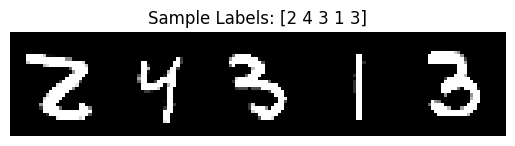

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


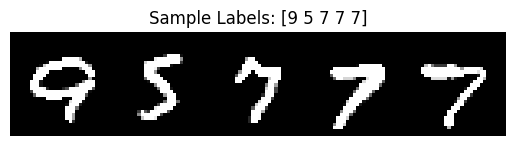

In [23]:
def check_sample(datamodule, batch_size=5):
    # Set to evaluation mode to avoid affecting training
    datamodule.setup('fit')
    
    # Create a DataLoader for the training set
    train_loader = DataLoader(datamodule.train_data, batch_size=batch_size, shuffle=True)
    
    # Get a batch
    images, labels = next(iter(train_loader))
    
    # Plot the images to visually check them
    grid = torchvision.utils.make_grid(images)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Convert from CxHxW to HxWxC
    plt.title(f"Sample Labels: {labels.numpy()}")
    plt.axis('off')
    plt.show()

# Check a sample before starting the training
if debug:
    check_sample(dm_base)
    check_sample(dm_lora)


In [24]:
# Trainer setup
trainer = Trainer(
    max_epochs=max_epochs,
    accelerator='auto',
    devices='auto',
    precision=precision,
    logger=tb_logger,
    enable_checkpointing=enable_checkpointing,
    num_sanity_val_steps=num_sanity_val_steps,
)

# Fit the model_base
trainer.fit(model_base, dm_base)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 55.1 K | train
1 | loss_fn  | CrossEntropyLoss   | 0      | train
2 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.


In [25]:
# Run the test on the base dataset
print("Evaluating model_base on digits 0-4...")
trainer.test(model_base, dm_base)

# Run the test on the lora dataset
print("Evaluating model_base on digits 5-9...")
trainer.test(model_base, dm_lora)


Evaluating model_base on digits 0-4...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9787896275520325     │
│         test_loss         │    0.06609625369310379    │
└───────────────────────────┴───────────────────────────┘

Evaluating model_base on digits 5-9...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            0.0            │
│         test_loss         │    11.663052558898926     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 11.663052558898926, 'test_acc': 0.0}]

In [26]:
# Save model weights so we can finetune them later
trainer.save_checkpoint("model_base.ckpt")
torch.save(model_base.state_dict(), "model_base.pt")

In [27]:
class MNISTLoRA(pl.LightningModule):
    def __init__(self, lr=1e-3, dims=(1, 28, 28), num_classes=10, hidden_size=64, lora_rank=8, lora_alpha=1):
        """
        Initialize the MNIST model with LoRA modifications.

        Args:
            lr (float): Learning rate for the optimizer.
            dims (tuple): Dimensions of input images, default (1, 28, 28).
            num_classes (int): Number of output classes for classification. Defaults to 10 for MNIST.
            hidden_size (int): Size of hidden layers.
            lora_rank (int): Rank for LoRA layers.
            lora_alpha (float): Scaling factor for LoRA adaptation.
        """
        super().__init__()
        self.lr = lr
        self.dims = dims
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha

        # Define the model structure
        self.model = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.dims[0] * self.dims[1] * self.dims[2], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.num_classes)
        )
        
        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        
        # Accuracy metric
        self.accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)
        
        # LoRA parameters (for layers 1, 2, and 3)
        self.l1_lora_A = nn.Parameter(torch.empty(self.dims[0] * self.dims[1] * self.dims[2], self.lora_rank))
        self.l1_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        self.l2_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l2_lora_B = nn.Parameter(torch.empty(self.lora_rank, hidden_size))
        self.l3_lora_A = nn.Parameter(torch.empty(hidden_size, self.lora_rank))
        self.l3_lora_B = nn.Parameter(torch.empty(self.lora_rank, self.num_classes))

        # Initialize LoRA parameters
        for n, p in self.named_parameters():
            if 'lora' in n:
                if n[-1] == 'A':
                    nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                elif n[-1] == 'B':
                    nn.init.zeros_(p)

        # Freeze non-LoRA parameters (only train the LoRA layers)
        for n, p in self.named_parameters():
            if 'lora' not in n:
                p.requires_grad = False

    def lora_linear(self, x, layer, lora_A, lora_B):
        """
        Performs a forward pass through a layer, augmented with LoRA.
        """
        h = layer(x)
        h += x @ (lora_A @ lora_B) * self.lora_alpha
        return h

    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = self.model[0](x)
        x = self.lora_linear(x, self.model[1], self.l1_lora_A, self.l1_lora_B)
        x = self.model[2](x)
        x = self.lora_linear(x, self.model[3], self.l2_lora_A, self.l2_lora_B)
        x = self.model[4](x)
        x = self.lora_linear(x, self.model[5], self.l3_lora_A, self.l3_lora_B)
        return x

    def configure_optimizers(self):
        """
        Configure the optimizer and learning rate scheduler.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "frequency": 1
            },
        }
    
    def common_step(self, batch, batch_idx, stage):
        """
        Defines a common step for training, validation, and testing.
        """
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
    
        # Log metrics dynamically based on the stage
        self.log(f"{stage}_loss", loss, on_step=(stage == "train"), on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", self.accuracy(logits, y), on_step=(stage == "train"), on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx, stage="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="val")
    
    def test_step(self, batch, batch_idx):
        self.common_step(batch, batch_idx, stage="test")


In [28]:
def lora_experiment(model_checkpoint, lora_class, lora_rank, datamodule, max_epochs=10, checkpoint_dir="./checkpoints"):
    """
    Fine-tune a model using LoRA with a specific rank.

    Args:
        model_checkpoint (str): Path to the pre-trained model checkpoint.
        lora_class (Type[pl.LightningModule]): LoRA model class to use.
        lora_rank (int): Rank for LoRA fine-tuning.
        datamodule (pl.LightningDataModule): PyTorch Lightning DataModule for training/testing.
        max_epochs (int): Maximum number of epochs for training. Default is 10.
        checkpoint_dir (str): Directory to save model checkpoints. Default is "checkpoints".

    Returns:
        Tuple[pl.LightningModule, float]: Trained LoRA model and test accuracy after fine-tuning.
    """
    # Load the pre-trained model
    state_dict = torch.load(model_checkpoint)
    model = lora_class(lora_rank=lora_rank)
    model.load_state_dict(state_dict, strict=False)
    
    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        devices='auto',
        precision=precision,
        logger=tb_logger,
        enable_checkpointing=enable_checkpointing,
        num_sanity_val_steps=num_sanity_val_steps,
        enable_model_summary=False,
    )

    # Fine-tune the model
    print(f"\nStarting LoRA fine-tuning with rank={lora_rank}...")
    trainer.fit(model, datamodule)

    # Evaluate on the test set
    result = trainer.test(model, datamodule, verbose=False)
    test_acc = result[0]['test_acc']
    print(f"LoRA Rank {lora_rank} - Test Accuracy: {test_acc:.4f}")
    
    # Save the model at the end
    trainer.save_checkpoint(f"{checkpoint_dir}/model_lora_rank_{lora_rank}.ckpt")

    return model, test_acc

# Run LoRA fine-tuning for multiple ranks.
lora_ranks = [1, 2, 4, 8, 16, 32, 64]
results = {}
models_lora = {}
for lora_rank in lora_ranks:
    model_lora, accuracy = lora_experiment(model_base_checkpoint, MNISTLoRA, lora_rank, dm_lora, max_epochs)
    results[lora_rank] = accuracy
    models_lora[lora_rank] = model_lora


C:\Users\NightFore\AppData\Local\Temp\ipykernel_135872\2601084439.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_checkpoint)
Using 16bit 


Starting LoRA fine-tuning with rank=1...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 1 - Test Accuracy: 0.5637

Starting LoRA fine-tuning with rank=2...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 2 - Test Accuracy: 0.6850

Starting LoRA fine-tuning with rank=4...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 4 - Test Accuracy: 0.8301

Starting LoRA fine-tuning with rank=8...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 8 - Test Accuracy: 0.8700

Starting LoRA fine-tuning with rank=16...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 16 - Test Accuracy: 0.9107

Starting LoRA fine-tuning with rank=32...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LoRA Rank 32 - Test Accuracy: 0.9241

Starting LoRA fine-tuning with rank=64...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

LoRA Rank 64 - Test Accuracy: 0.9243



Checking with Base Model (model_base) before fine-tuning using LoRA:

Predictions and True Labels for the batch:


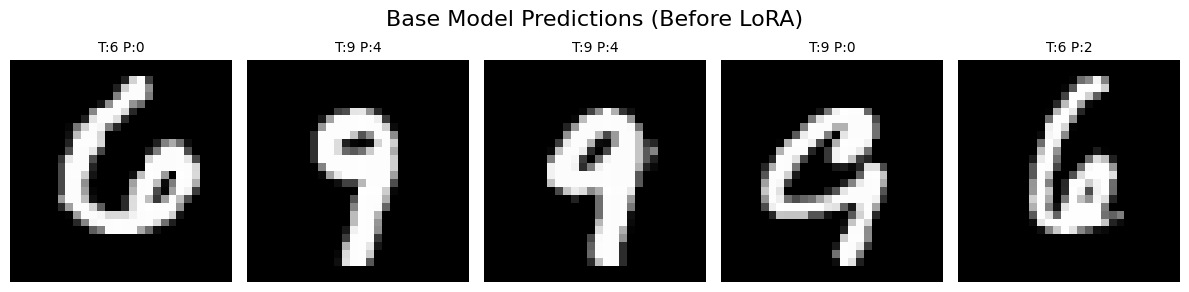

Debugging trained LoRA models for different ranks:

Checking LoRA model with rank=1:

Predictions and True Labels for the batch:


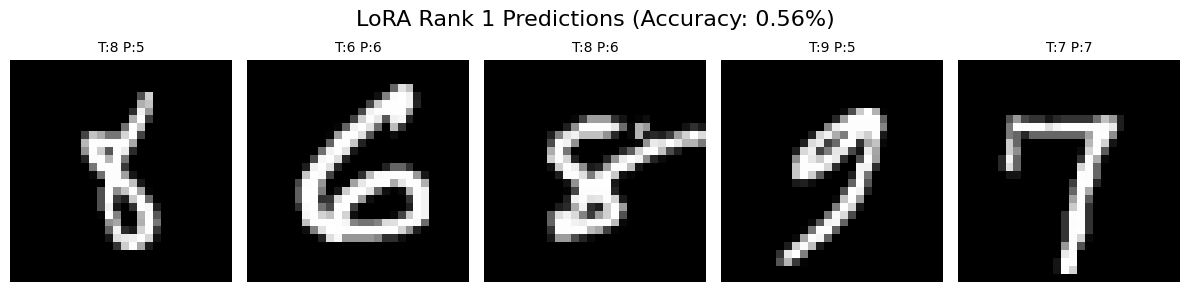


Checking LoRA model with rank=2:

Predictions and True Labels for the batch:


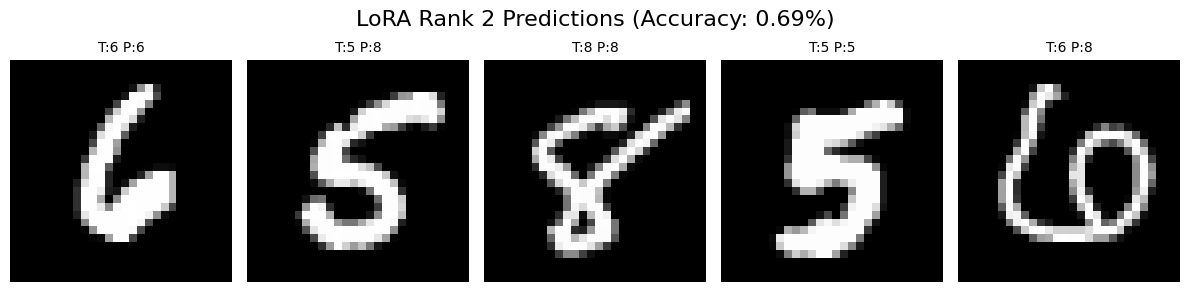


Checking LoRA model with rank=4:

Predictions and True Labels for the batch:


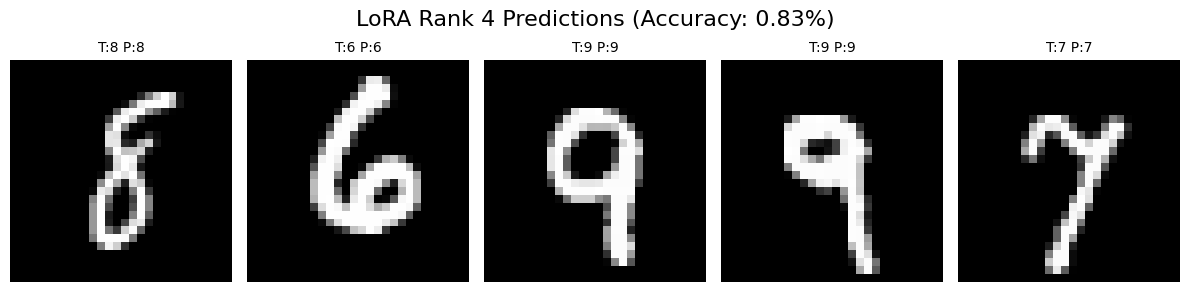


Checking LoRA model with rank=8:

Predictions and True Labels for the batch:


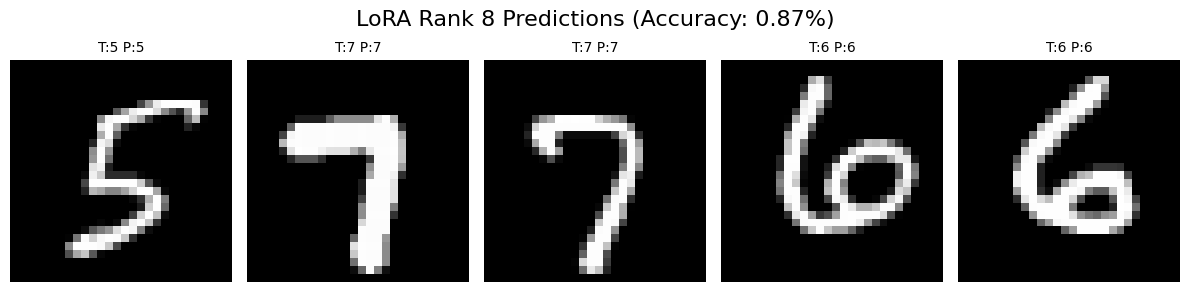


Checking LoRA model with rank=16:

Predictions and True Labels for the batch:


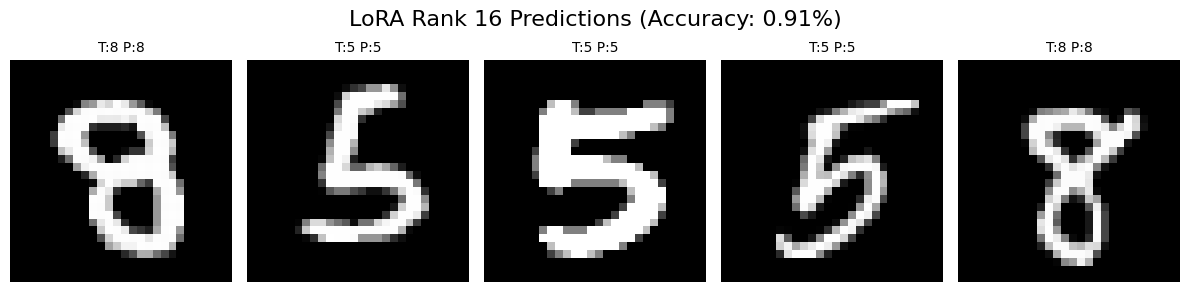


Checking LoRA model with rank=32:

Predictions and True Labels for the batch:


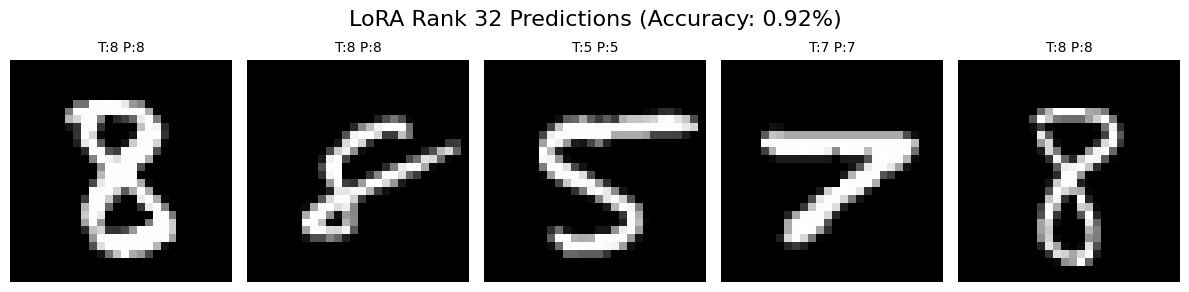


Checking LoRA model with rank=64:

Predictions and True Labels for the batch:


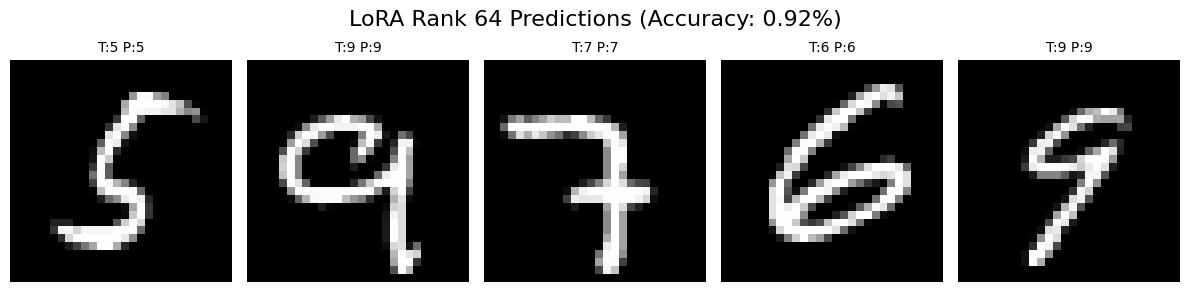

In [30]:
def get_sample(datamodule, batch_size=5, setup_stage="test"):
    datamodule.setup(stage=setup_stage)
    loader = DataLoader(datamodule.test_data, batch_size=batch_size, shuffle=True)
    return next(iter(loader))
    
def predict_and_visualize_batch(images, labels, model, title="Predictions", fig_size=(12, 3)):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

    # Create grid plot
    fig, axes = plt.subplots(1, len(images), figsize=fig_size)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.set_title(f"T:{labels[i].item()} P:{predictions[i].item()}", fontsize=10)
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def check_datamodule(datamodule, model=None, batch_size=5, debug=False, title="Dataset Samples", fig_size=(12, 3)):
    images, labels = get_sample(datamodule, batch_size=batch_size)

    # Show predictions only if model is provided
    if model is not None:
        print("\nPredictions and True Labels for the batch:")
        predict_and_visualize_batch(images, labels, model, title=title, fig_size=fig_size)

    return images


# Initial Check using model_base
print("\nChecking with Base Model (model_base) before fine-tuning using LoRA:")
check_datamodule(dm_lora, model=model_base, debug=True, title="Base Model Predictions (Before LoRA)", fig_size=(12, 3))

# Debugging for trained LoRA models with accuracy from results
if debug:
    print("Debugging trained LoRA models for different ranks:")
    for lora_rank in lora_ranks:
        model = models_lora.get(lora_rank)
        accuracy = results.get(lora_rank, "N/A")  # Fetch accuracy from the results dictionary
        
        # Format accuracy to 2 decimal places
        formatted_accuracy = f"{accuracy:.2f}" if accuracy != "N/A" else accuracy
        
        print(f"\nChecking LoRA model with rank={lora_rank}:")
        title_with_accuracy = f"LoRA Rank {lora_rank} Predictions (Accuracy: {formatted_accuracy}%)"
        check_datamodule(dm_lora, model=model, debug=True, title=title_with_accuracy, fig_size=(12, 3))